In [94]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import numpy as np
import sklearn
import re
import math
import joblib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [95]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertForMaskedLM

from sklearn.metrics import (
    recall_score,
    precision_score
  )

from sklearn.metrics import multilabel_confusion_matrix

In [96]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [97]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [98]:
time_now = pd.Timestamp.now().strftime("%m-%d-%H-%M")
print(f"Time now: {time_now}")

Time now: 06-02-22-48


# Config

In [99]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'jackaduma/SecRoBERTa'
        self.NUM_LABELS_TA = 14
        self.NUM_LABELS_TE = 185

        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 320
        self.BATCH_SIZE = 16

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 50

In [100]:
TACTIC = ['TA0001', 'TA0002', 'TA0003', 'TA0004', 'TA0005', 'TA0006', 'TA0007', 'TA0008', 'TA0009', 'TA0010', 'TA0011', 'TA0040', 'TA0042', 'TA0043']
TECHNIQUE = ['T1001', 'T1003', 'T1005', 'T1006', 'T1007', 'T1008', 'T1010', 'T1011', 'T1012', 'T1014', 'T1016', 'T1018', 'T1020', 'T1021', 'T1025', 'T1027', 'T1029', 'T1030', 'T1033', 'T1036', 'T1037', 'T1039', 'T1040', 'T1041', 'T1046', 'T1047', 'T1048', 'T1049', 'T1052', 'T1053', 'T1055', 'T1056', 'T1057', 'T1059', 'T1068', 'T1069', 'T1071', 'T1072', 'T1074', 'T1078', 'T1080', 'T1082', 'T1083', 'T1087', 'T1090', 'T1091', 'T1092', 'T1095', 'T1098', 'T1102', 'T1104', 'T1105', 'T1106', 'T1110', 'T1111', 'T1112', 'T1113', 'T1114', 'T1115', 'T1119', 'T1120', 'T1123', 'T1124', 'T1125', 'T1127', 'T1129', 'T1132', 'T1133', 'T1134', 'T1135', 'T1136', 'T1137', 'T1140', 'T1176', 'T1185', 'T1187', 'T1189', 'T1190', 'T1195', 'T1197', 'T1199', 'T1200', 'T1201', 'T1202', 'T1203', 'T1204', 'T1205', 'T1207', 'T1210', 'T1211', 'T1212', 'T1213', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1482', 'T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1497', 'T1498', 'T1499', 'T1505', 'T1518', 'T1525', 'T1526', 'T1528', 'T1529', 'T1531', 'T1534', 'T1535', 'T1537', 'T1538', 'T1539', 'T1542', 'T1543', 'T1546', 'T1547', 'T1548', 'T1550', 'T1552', 'T1553', 'T1555', 'T1556', 'T1557', 'T1558', 'T1559', 'T1560', 'T1561', 'T1562', 'T1563', 'T1564', 'T1565', 'T1566', 'T1567', 'T1568', 'T1569', 'T1570', 'T1571', 'T1572', 'T1573', 'T1574', 'T1578', 'T1580', 'T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598', 'T1599', 'T1600', 'T1601', 'T1602', 'T1606', 'T1608', 'T1609', 'T1610', 'T1611', 'T1612', 'T1613', 'T1614', 'T1615', 'T1619', 'T1620', 'T1621', 'T1622', 'T1647']
TACTICS_TECHNIQUES_RELATIONSHIP_DF = {
"TA0001":pd.Series(['T1078', 'T1091', 'T1133', 'T1189', 'T1190', 'T1195', 'T1199', 'T1200', 'T1566', 'T1659', 'T1669']),
"TA0002":pd.Series(['T1047', 'T1053', 'T1059', 'T1072', 'T1106', 'T1129', 'T1203', 'T1204', 'T1559', 'T1569', 'T1609', 'T1610', 'T1648', 'T1651', 'T1674', 'T1675']),
"TA0003":pd.Series(['T1037', 'T1053', 'T1078', 'T1098', 'T1112', 'T1133', 'T1136', 'T1137', 'T1176', 'T1197', 'T1205', 'T1505', 'T1525', 'T1542', 'T1543', 'T1546', 'T1547', 'T1554', 'T1556', 'T1574', 'T1653', 'T1668', 'T1671']),
"TA0004":pd.Series(['T1037', 'T1053', 'T1055', 'T1068', 'T1078', 'T1098', 'T1134', 'T1484', 'T1543', 'T1546', 'T1547', 'T1548', 'T1574', 'T1611']),
"TA0005":pd.Series(['T1006', 'T1014', 'T1027', 'T1036', 'T1055', 'T1070', 'T1078', 'T1112', 'T1127', 'T1134', 'T1140', 'T1197', 'T1202', 'T1205', 'T1207', 'T1211', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1484', 'T1497', 'T1535', 'T1542', 'T1548', 'T1550', 'T1553', 'T1556', 'T1562', 'T1564', 'T1574', 'T1578', 'T1599', 'T1600', 'T1601', 'T1610', 'T1612', 'T1620', 'T1622', 'T1647', 'T1656', 'T1666', 'T1672']),
"TA0006":pd.Series(['T1003', 'T1040', 'T1056', 'T1110', 'T1111', 'T1187', 'T1212', 'T1528', 'T1539', 'T1552', 'T1555', 'T1556', 'T1557', 'T1558', 'T1606', 'T1621', 'T1649']),
"TA0007":pd.Series(['T1007', 'T1010', 'T1012', 'T1016', 'T1018', 'T1033', 'T1040', 'T1046', 'T1049', 'T1057', 'T1069', 'T1082', 'T1083', 'T1087', 'T1120', 'T1124', 'T1135', 'T1201', 'T1217', 'T1482', 'T1497', 'T1518', 'T1526', 'T1538', 'T1580', 'T1613', 'T1614', 'T1615', 'T1619', 'T1622', 'T1652', 'T1654', 'T1673']),
"TA0008":pd.Series(['T1021', 'T1072', 'T1080', 'T1091', 'T1210', 'T1534', 'T1550', 'T1563', 'T1570']),
"TA0009":pd.Series(['T1005', 'T1025', 'T1039', 'T1056', 'T1074', 'T1113', 'T1114', 'T1115', 'T1119', 'T1123', 'T1125', 'T1185', 'T1213', 'T1530', 'T1557', 'T1560', 'T1602']),
"TA0010":pd.Series(['T1011', 'T1020', 'T1029', 'T1030', 'T1041', 'T1048', 'T1052', 'T1537', 'T1567']),
"TA0011":pd.Series(['T1001', 'T1008', 'T1071', 'T1090', 'T1092', 'T1095', 'T1102', 'T1104', 'T1105', 'T1132', 'T1205', 'T1219', 'T1568', 'T1571', 'T1572', 'T1573', 'T1659', 'T1665']),
"TA0040":pd.Series(['T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1498', 'T1499', 'T1529', 'T1531', 'T1561', 'T1565', 'T1657', 'T1667']),                
"TA0042":pd.Series(['T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1608', 'T1650']),
"TA0043":pd.Series(['T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598'])
}

In [101]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

In [102]:
print(df_tactic_labels)

      TA0001  TA0002  TA0003  TA0004  TA0005  TA0006  TA0007  TA0008  TA0009  \
0          1       1       0       0       0       0       0       0       0   
1          1       1       0       0       0       0       0       0       0   
2          0       1       0       0       0       1       0       0       0   
3          1       1       0       0       0       0       0       0       0   
4          1       0       0       1       1       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1513       0       1       1       0       0       0       0       0       0   
1514       0       0       0       0       0       0       0       0       0   
1515       0       0       0       1       0       0       0       0       0   
1516       0       1       0       0       0       0       0       0       1   
1517       0       0       0       0       0       0       0       0       0   

      TA0010  TA0011  TA0040  TA0042  T

In [103]:
print(df_technique_labels)

      T1001  T1003  T1005  T1006  T1007  T1008  T1010  T1011  T1012  T1014  \
0         0      0      0      0      0      0      0      0      0      0   
1         0      0      0      0      0      0      0      0      0      0   
2         0      1      0      0      0      0      0      0      0      0   
3         0      0      0      0      0      0      0      0      0      0   
4         0      0      0      0      0      0      0      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1513      0      0      0      0      0      0      0      0      0      0   
1514      0      0      0      0      0      0      0      0      0      0   
1515      0      0      0      0      0      0      0      0      0      0   
1516      0      0      1      0      0      0      0      0      0      0   
1517      0      0      0      0      0      0      0      0      0      0   

      ...  T1611  T1612  T1613  T1614  T1615  T1619  T1620  T16

In [104]:
df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)


# Data processing

In [105]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [106]:
import nltk

resources = [
    "punkt",
    "stopwords",
    "wordnet",
    "omw-1.4",
    "averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng"
]

for res in resources:
    try:
        nltk.data.find(res)
        print(f"{res} ✅ 已安裝")
    except LookupError:
        print(f"{res} ⛔ 未安裝，開始下載...")
        nltk.download(res)


punkt ⛔ 未安裝，開始下載...
stopwords ⛔ 未安裝，開始下載...
wordnet ⛔ 未安裝，開始下載...
omw-1.4 ⛔ 未安裝，開始下載...
averaged_perceptron_tagger ⛔ 未安裝，開始下載...
averaged_perceptron_tagger_eng ⛔ 未安裝，開始下載...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_t

In [107]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def ioc_sub(text):
    def reg_handler(obj):
        s = obj.group(1)
        s = ' '.join(s.split('\\'))
        return s

    def file_handler(obj):
        s = obj.group(2)
        s = s.split('\\')[-1]
        return s
    
    text = re.sub(r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|\[\.\])){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\/([0-2][0-9]|3[0-2]|[0-9]))?', 'IPv4', text)
    text = re.sub(r'\b(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\b', 'IP', text)
    text = re.sub(r'\b(CVE\-[0-9]{4}\-[0-9]{4,6})\b', 'CVE', text)
    text = re.sub(r'CVE-[0-9]{4}-[0-9]{4,6}', 'vulnerability', text)
    text = re.sub(r'\b([a-z][_a-z0-9-.]+@[a-z0-9-]+\.[a-z]+)\b', 'email', text)
    text = re.sub(r'\b((HKLM|HKCU|HKCR|HKU|HKCC)\\[\\A-Za-z0-9-_]+)\b', reg_handler, text)
    text = re.sub(r'\b([a-zA-Z]{1}:\\([0-9a-zA-Z_\.\-\/\\]+))\b', file_handler, text)
    text = re.sub(r'\b([a-f0-9]{32}|[A-F0-9]{32})\b', 'MD5', text)
    text = re.sub(r'\b([a-f0-9]{40}|[A-F0-9]{40})\b', 'SHA1', text)
    text = re.sub(r'\b([a-f0-9]{64}|[A-F0-9]{64})\b', 'SHA256', text)
    text = re.sub(r'\d+:[A-Za-z0-9/+]+:[A-Za-z0-9/+]+', 'ssdeep', text)
    text = re.sub(r'\b[a-fA-F\d]{32}\b|\b[a-fA-F\d]{40}\b|\b[a-fA-F\d]{64}\b', 'hash', text)
    text = re.sub(r'h[tx][tx]ps?:[\\\/][\\\/](?:[0-9a-zA-Z_\.\-\/\\]|\[\.\])+', 'URL', text)
    text = re.sub(r'((?:[0-9a-zA-Z_\-]+\.)+(?:(?!exe|dll)[a-z]{2,4}))', 'domain', text)
    text = re.sub(r'[a-fA-F0-9]{16}', '', text)
    text = re.sub(r'[0-9]{8}', '', text)
    text = re.sub(r'x[A-Fa-f0-9]{2}', '', text)
    
    return text

def rmstopword_and_lemmatize(text):
    token = [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]
    # tag = pos_tag(token)
    tag = nltk.pos_tag(token, lang='eng')
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(list(map(lambda x: lemmatizer.lemmatize(x[0], pos=get_wordnet_pos(x[1])), tag)))
    
    return text

def preprocess(text):
    text = str(text)
    #text = text.lower()
    text = re.sub(r'etc\.', '', text)
    text = re.sub(r'et al\.', '', text)
    text = re.sub(r'e\.g\.', '', text)
    text = re.sub(r'i\.e\.', '', text)
    #text = re.sub(r'\[.\]', '.', text)
    text = re.sub(r'\[\d+\]', '', text)
    
    text = ioc_sub(text)
    
    text = re.sub(r'[^A-Za-z0-9_\[\]]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = rmstopword_and_lemmatize(text)
    
    text = re.sub(r'[\[\]]', ' ', text)
    text = re.sub(r' [a-z0-9] ', '', text)
    
    return text


In [108]:
df['text_clean'] = df['Text'].map(lambda t: preprocess(t))

In [109]:
print(df['text_clean'][0])

waspthemes visual cs style editor aka yellow pencil visual theme customizer plugin2wordpress allows yp_option_update csrf demonstrate use yp_remote_get obtain admin access


In [110]:
print(df.iloc[0])

ID                                                    CVE_2019_11886
Text               The WaspThemes Visual CSS Style Editor (aka ye...
TA0001                                                             1
TA0002                                                             1
TA0003                                                             0
                                         ...                        
T1622                                                              0
T1647                                                              0
tactic_label              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
technique_label    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
text_clean         waspthemes visual cs style editor aka yellow p...
Name: 0, Length: 204, dtype: object


# Dataset & Dataloader

In [111]:
def get_texts(df):
    texts = df['text']
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels = df['labels'].values
    return labels

def get_ids(df):
    ids = df['ID'].values.tolist()

In [112]:
from torch.utils.data import Dataset, DataLoader
class TransformerDataset_ta(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_ta, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [113]:

class TransformerDataset_te(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_te, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [114]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)

In [115]:
df_ta_train = train[['text_clean', 'tactic_label']]
df_ta_val = validation[['text_clean', 'tactic_label']]
df_ta_test = test[['text_clean', 'tactic_label']]
df_ta_train = df_ta_train.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_val = df_ta_val.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_test = df_ta_test.rename(columns={'text_clean':'text', 'tactic_label':'labels'})


In [116]:
# df_te_train = df.iloc[train.index][['text_clean', 'technique_label']]
# df_te_val = df.iloc[validation.index][['text_clean', 'technique_label']]
# df_te_test = df.iloc[test.index][['text_clean', 'technique_label']]
# df_te_train = df_te_train.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_val = df_te_val.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_test = df_te_test.rename(columns={'text_clean':'text', 'technique_label':'labels'})

In [117]:
train_data_ta = TransformerDataset_ta(df_ta_train, range(len(df_ta_train)))
val_data_ta = TransformerDataset_ta(df_ta_val, range(len(df_ta_val)))
test_data_ta = TransformerDataset_ta(df_ta_test, range(len(df_ta_test)))

In [118]:
# train_data_te = TransformerDataset_te(df_ta_train, range(len(df_te_train)))
# val_data_te = TransformerDataset_te(df_ta_val, range(len(df_te_val)))
# test_data_te = TransformerDataset_te(df_ta_test, range(len(df_te_test)))

In [119]:
train_dataloader_ta = DataLoader(train_data_ta, batch_size=Config().BATCH_SIZE)
val_dataloader_ta = DataLoader(val_data_ta, batch_size=Config().BATCH_SIZE)
test_dataloader_ta = DataLoader(test_data_ta, batch_size=Config().BATCH_SIZE)

In [120]:
# train_dataloader_te = DataLoader(train_data_te, batch_size=Config().BATCH_SIZE)
# val_dataloader_te = DataLoader(val_data_te, batch_size=Config().BATCH_SIZE)
# test_dataloader_te = DataLoader(test_data_te, batch_size=Config().BATCH_SIZE)

In [121]:
train_dataloader = train_dataloader_ta
val_dataloader = val_dataloader_ta
test_dataloader = test_dataloader_ta

In [122]:
b = next(iter(train_dataloader_ta))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 320])
attention_mask shape: torch.Size([16, 320])
labels shape: torch.Size([16, 14])


# Model

In [123]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.transformer_model = AutoModel.from_pretrained(
                Config().MODEL_PATH
        )
        self.dropout = nn.Dropout(0.3)

        self.output = nn.Linear(768, Config().NUM_LABELS_TA)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None
        ):

        _, o2 = self.transformer_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.dropout(o2)
        out = self.output(x)

        return out

# Train and test

In [124]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

In [125]:
metrics_log = [] 

In [126]:
def val(model, val_dataloader, criterion, is_final_test=False):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED, device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)


    if (is_final_test is True):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred
    elif (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred

    return val_weighted_f1_score



In [127]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    global device
    nv = Config().N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    train_losses = []

    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)


    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

In [128]:
def run():
    global train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader, model
    torch.manual_seed(Config().SEED)

    criterion = nn.BCEWithLogitsLoss()

    if Config().FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=Config().LR)

    num_training_steps = len(train_dataloader) * Config().EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(Config().EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader, criterion)

        if Config().SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 'secroberta_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

# Tactic_multi model

In [129]:
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [130]:
project_dir = './'
config = Config()
device = Config().DEVICE
model = Model()
model.to(device)

Model(
  (transformer_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [131]:
best_model_ta, best_val_weighted_f1_score_ta = run()

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 0:   1%|▏         | 1/76 [00:00<00:43,  1.72it/s]

{'f1_sampled': 0.26651144907723856, 'f1_micro': 0.2832618025751073, 'f1_macro': 0.1372033023004777, 'f_05_sample': 0.21686264486099258, 'f_05_micro': 0.22029372496662217, 'f_05_macro': 0.10794893007977609, 'precision_sampled': 0.19532424812030072, 'precision_micro': 0.19186046511627908, 'precision_macro': 0.09471658478649723, 'recall_sampled': 0.5342105263157894, 'recall_micro': 0.5409836065573771, 'recall_macro': 0.2723533525080612, 'accuracy': 0.0, 'coverage_error': np.float64(10.75), 'label_ranking_loss': np.float64(0.5708187645687646), 'lrap': np.float64(0.25431547619047623)}


Epoch 0: 100%|██████████| 76/76 [00:04<00:00, 16.21it/s]


Training loss: 0.326834429839724
{'f1_sampled': 0.12039473684210525, 'f1_micro': 0.17266187050359713, 'f1_macro': 0.04124549374425673, 'f_05_sample': 0.13463345864661655, 'f_05_micro': 0.3157894736842105, 'f_05_macro': 0.05154440154440154, 'precision_sampled': 0.1513157894736842, 'precision_micro': 0.7058823529411765, 'precision_macro': 0.12121212121212122, 'recall_sampled': 0.10745614035087718, 'recall_micro': 0.09836065573770492, 'recall_macro': 0.032550099613266145, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}
--- Best Model. Val: -inf -> 0.12420608204021706


Epoch 1:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 1:   1%|▏         | 1/76 [00:00<00:36,  2.07it/s]

{'f1_sampled': 0.15592105263157893, 'f1_micro': 0.21379310344827587, 'f1_macro': 0.046771292103467525, 'f_05_sample': 0.1749295112781955, 'f_05_micro': 0.3621495327102804, 'f_05_macro': 0.053126916002452486, 'precision_sampled': 0.19736842105263158, 'precision_micro': 0.6739130434782609, 'precision_macro': 0.11904761904761904, 'recall_sampled': 0.1387061403508772, 'recall_micro': 0.12704918032786885, 'recall_macro': 0.041984061877417087, 'accuracy': 0.14473684210526316, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}


Epoch 1: 100%|██████████| 76/76 [00:04<00:00, 17.35it/s]


Training loss: 0.2647015519048038
{'f1_sampled': 0.26265664160401003, 'f1_micro': 0.3560830860534125, 'f1_macro': 0.10904045828857858, 'f_05_sample': 0.2755260547201337, 'f_05_micro': 0.487012987012987, 'f_05_macro': 0.12142515051997808, 'precision_sampled': 0.29276315789473684, 'precision_micro': 0.6451612903225806, 'precision_macro': 0.1406272299129442, 'recall_sampled': 0.2609649122807018, 'recall_micro': 0.2459016393442623, 'recall_macro': 0.0991023819289816, 'accuracy': 0.19078947368421054, 'coverage_error': np.float64(12.375), 'label_ranking_loss': np.float64(0.8125), 'lrap': np.float64(0.3303571428571428)}
--- Best Model. Val: 0.12420608204021706 -> 0.2700357451004561


Epoch 2:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 2:   5%|▌         | 4/76 [00:00<00:08,  8.54it/s]

{'f1_sampled': 0.27910401002506263, 'f1_micro': 0.3710144927536232, 'f1_macro': 0.11008080188866189, 'f_05_sample': 0.2934354114452799, 'f_05_micro': 0.49382716049382713, 'f_05_macro': 0.11994606747166474, 'precision_sampled': 0.3125, 'precision_micro': 0.6336633663366337, 'precision_macro': 0.13749067024929093, 'recall_sampled': 0.27741228070175444, 'recall_micro': 0.26229508196721313, 'recall_macro': 0.10449321750849642, 'accuracy': 0.19078947368421054, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.8221153846153846), 'lrap': np.float64(0.26785714285714285)}


Epoch 2: 100%|██████████| 76/76 [00:04<00:00, 18.10it/s]


Training loss: 0.22742333086697678
{'f1_sampled': 0.3081766917293233, 'f1_micro': 0.39215686274509803, 'f1_macro': 0.15990407346928898, 'f_05_sample': 0.3341361215538847, 'f_05_micro': 0.5028735632183908, 'f_05_macro': 0.19485103621843466, 'precision_sampled': 0.3684210526315789, 'precision_micro': 0.6194690265486725, 'precision_macro': 0.2559002528214351, 'recall_sampled': 0.293859649122807, 'recall_micro': 0.28688524590163933, 'recall_macro': 0.134781165643914, 'accuracy': 0.18421052631578946, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.780448717948718), 'lrap': np.float64(0.300595238095238)}
--- Best Model. Val: 0.2700357451004561 -> 0.329160708726211


Epoch 3:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 3:   5%|▌         | 4/76 [00:00<00:08,  8.72it/s]

{'f1_sampled': 0.31146616541353384, 'f1_micro': 0.38904109589041097, 'f1_macro': 0.15806806794475886, 'f_05_sample': 0.33742559523809523, 'f_05_micro': 0.4876373626373626, 'f_05_macro': 0.18708751898765175, 'precision_sampled': 0.3717105263157895, 'precision_micro': 0.5867768595041323, 'precision_macro': 0.23772589844018416, 'recall_sampled': 0.29714912280701755, 'recall_micro': 0.29098360655737704, 'recall_macro': 0.13733218605207728, 'accuracy': 0.18421052631578946, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.780448717948718), 'lrap': np.float64(0.300595238095238)}


Epoch 3: 100%|██████████| 76/76 [00:04<00:00, 18.04it/s]


Training loss: 0.18788234144449234
{'f1_sampled': 0.3478070175438596, 'f1_micro': 0.4368421052631579, 'f1_macro': 0.18924917297300764, 'f_05_sample': 0.36900964532543484, 'f_05_micro': 0.5266497461928934, 'f_05_macro': 0.2199418158457244, 'precision_sampled': 0.3980263157894737, 'precision_micro': 0.6102941176470589, 'precision_macro': 0.2567755239747721, 'recall_sampled': 0.34484649122807015, 'recall_micro': 0.3401639344262295, 'recall_macro': 0.1617827052652598, 'accuracy': 0.19078947368421054, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.4077380952380952)}
--- Best Model. Val: 0.329160708726211 -> 0.38662413004472757


Epoch 4:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 4:   5%|▌         | 4/76 [00:00<00:08,  8.46it/s]

{'f1_sampled': 0.3507832080200501, 'f1_micro': 0.4368421052631579, 'f1_macro': 0.18854916157718823, 'f_05_sample': 0.3716203387256019, 'f_05_micro': 0.5266497461928934, 'f_05_macro': 0.21772660568261934, 'precision_sampled': 0.40131578947368424, 'precision_micro': 0.6102941176470589, 'precision_macro': 0.2532760472610097, 'recall_sampled': 0.3470394736842105, 'recall_micro': 0.3401639344262295, 'recall_macro': 0.16266713922752393, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.4077380952380952)}


Epoch 4: 100%|██████████| 76/76 [00:04<00:00, 17.98it/s]


Training loss: 0.15316002610090532
{'f1_sampled': 0.3734962406015037, 'f1_micro': 0.43309002433090027, 'f1_macro': 0.18410925732950637, 'f_05_sample': 0.3890949145883356, 'f_05_micro': 0.48793859649122806, 'f_05_macro': 0.207042261873923, 'precision_sampled': 0.41118421052631576, 'precision_micro': 0.5329341317365269, 'precision_macro': 0.23121838478981335, 'recall_sampled': 0.3793859649122807, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.16568075403480392, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7179487179487178), 'lrap': np.float64(0.3541666666666667)}
--- Best Model. Val: 0.38662413004472757 -> 0.38763339908796945


Epoch 5:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 5:   5%|▌         | 4/76 [00:00<00:08,  8.24it/s]

{'f1_sampled': 0.38270676691729316, 'f1_micro': 0.44552058111380144, 'f1_macro': 0.19259160606810904, 'f_05_sample': 0.3968368071986493, 'f_05_micro': 0.5, 'f_05_macro': 0.2154130422614696, 'precision_sampled': 0.41776315789473684, 'precision_micro': 0.5443786982248521, 'precision_macro': 0.23820788999360426, 'recall_sampled': 0.39144736842105265, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.1730149377082733, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7179487179487178), 'lrap': np.float64(0.3541666666666667)}


Epoch 5: 100%|██████████| 76/76 [00:04<00:00, 17.96it/s]


Training loss: 0.13059766414134125
{'f1_sampled': 0.3429824561403509, 'f1_micro': 0.41711229946524064, 'f1_macro': 0.1823922384202948, 'f_05_sample': 0.3687604427736007, 'f_05_micro': 0.5104712041884817, 'f_05_macro': 0.21497253573061417, 'precision_sampled': 0.40131578947368424, 'precision_micro': 0.6, 'precision_macro': 0.2539971617206548, 'recall_sampled': 0.33114035087719296, 'recall_micro': 0.319672131147541, 'recall_macro': 0.1528445281915582, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.8333333333333333), 'lrap': np.float64(0.3005952380952381)}


Epoch 6:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 6:   5%|▌         | 4/76 [00:00<00:08,  8.99it/s]

{'f1_sampled': 0.3539473684210526, 'f1_micro': 0.42744063324538256, 'f1_macro': 0.18638186719304364, 'f_05_sample': 0.3789943609022557, 'f_05_micro': 0.5165816326530612, 'f_05_macro': 0.21750250676048774, 'precision_sampled': 0.41118421052631576, 'precision_micro': 0.6, 'precision_macro': 0.25574277956796754, 'recall_sampled': 0.3442982456140351, 'recall_micro': 0.3319672131147541, 'recall_macro': 0.15950819994956955, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.8333333333333333), 'lrap': np.float64(0.3005952380952381)}


Epoch 6: 100%|██████████| 76/76 [00:04<00:00, 18.15it/s]


Training loss: 0.10353240321733449
{'f1_sampled': 0.3834586466165413, 'f1_micro': 0.46153846153846156, 'f1_macro': 0.20113760828622115, 'f_05_sample': 0.4076447127433969, 'f_05_micro': 0.5284090909090909, 'f_05_macro': 0.23645838742577535, 'precision_sampled': 0.44188596491228066, 'precision_micro': 0.5849056603773585, 'precision_macro': 0.3329838856813273, 'recall_sampled': 0.3807017543859649, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.178567113848736, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.4077380952380952)}
--- Best Model. Val: 0.38763339908796945 -> 0.4149339230011876


Epoch 7:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 7:   5%|▌         | 4/76 [00:00<00:08,  8.65it/s]

{'f1_sampled': 0.39442355889724307, 'f1_micro': 0.47, 'f1_macro': 0.21168935017318763, 'f_05_sample': 0.42153360163228587, 'f_05_micro': 0.5414746543778802, 'f_05_macro': 0.2503452401626704, 'precision_sampled': 0.45833333333333326, 'precision_micro': 0.6025641025641025, 'precision_macro': 0.3448425897641863, 'recall_sampled': 0.38728070175438595, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18474574061801086, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.4077380952380952)}


Epoch 7: 100%|██████████| 76/76 [00:04<00:00, 18.05it/s]


Training loss: 0.0844117702033959
{'f1_sampled': 0.3854323308270676, 'f1_micro': 0.458628841607565, 'f1_macro': 0.20519428401238096, 'f_05_sample': 0.39402793843583317, 'f_05_micro': 0.5052083333333334, 'f_05_macro': 0.2388611113169741, 'precision_sampled': 0.4144736842105263, 'precision_micro': 0.5418994413407822, 'precision_macro': 0.32655706727135303, 'recall_sampled': 0.41250000000000003, 'recall_micro': 0.3975409836065574, 'recall_macro': 0.18198154183882262, 'accuracy': 0.19078947368421054, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6077724358974359), 'lrap': np.float64(0.3764880952380952)}
--- Best Model. Val: 0.4149339230011876 -> 0.4232508050381357


Epoch 8:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 8:   5%|▌         | 4/76 [00:00<00:08,  8.56it/s]

{'f1_sampled': 0.3920112781954887, 'f1_micro': 0.4597156398104265, 'f1_macro': 0.20406676227109663, 'f_05_sample': 0.4024343711843712, 'f_05_micro': 0.5073221757322176, 'f_05_macro': 0.23607245840095853, 'precision_sampled': 0.4243421052631579, 'precision_micro': 0.5449438202247191, 'precision_macro': 0.32159585145533626, 'recall_sampled': 0.41578947368421054, 'recall_micro': 0.3975409836065574, 'recall_macro': 0.18177645570264542, 'accuracy': 0.19736842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6077724358974359), 'lrap': np.float64(0.3764880952380952)}


Epoch 8: 100%|██████████| 76/76 [00:04<00:00, 18.04it/s]


Training loss: 0.07257016395267687
{'f1_sampled': 0.36547619047619045, 'f1_micro': 0.4444444444444444, 'f1_macro': 0.1966169134976267, 'f_05_sample': 0.3818098933230512, 'f_05_micro': 0.5067567567567568, 'f_05_macro': 0.2361773252686512, 'precision_sampled': 0.40789473684210525, 'precision_micro': 0.5590062111801242, 'precision_macro': 0.2888142816935387, 'recall_sampled': 0.37521929824561406, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.16614690544921354, 'accuracy': 0.19736842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 9:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 9:   5%|▌         | 4/76 [00:00<00:08,  8.94it/s]

{'f1_sampled': 0.3731516290726817, 'f1_micro': 0.44768856447688565, 'f1_macro': 0.1978988829921457, 'f_05_sample': 0.38692685238737873, 'f_05_micro': 0.5043859649122807, 'f_05_macro': 0.2339911889488957, 'precision_sampled': 0.41118421052631576, 'precision_micro': 0.5508982035928144, 'precision_macro': 0.28163030178812104, 'recall_sampled': 0.38837719298245615, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.16993184333741226, 'accuracy': 0.19736842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 9: 100%|██████████| 76/76 [00:04<00:00, 18.23it/s]


Training loss: 0.06049745569103643
{'f1_sampled': 0.34407894736842104, 'f1_micro': 0.42487046632124353, 'f1_macro': 0.18862946587085538, 'f_05_sample': 0.3624907621618148, 'f_05_micro': 0.5049261083743842, 'f_05_macro': 0.23257348682481313, 'precision_sampled': 0.3892543859649123, 'precision_micro': 0.5774647887323944, 'precision_macro': 0.2901708410636982, 'recall_sampled': 0.34758771929824556, 'recall_micro': 0.3360655737704918, 'recall_macro': 0.153640137999605, 'accuracy': 0.19736842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 10:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 10:   5%|▌         | 4/76 [00:00<00:07,  9.14it/s]

{'f1_sampled': 0.34157268170426064, 'f1_micro': 0.4213197969543147, 'f1_macro': 0.1874555206698064, 'f_05_sample': 0.3577111850138166, 'f_05_micro': 0.49170616113744076, 'f_05_macro': 0.22752906129018283, 'precision_sampled': 0.3826754385964913, 'precision_micro': 0.5533333333333333, 'precision_macro': 0.27974735313579885, 'recall_sampled': 0.3489035087719298, 'recall_micro': 0.3401639344262295, 'recall_macro': 0.15519293303066087, 'accuracy': 0.19078947368421054, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 10: 100%|██████████| 76/76 [00:04<00:00, 18.20it/s]


Training loss: 0.04968125118236793
{'f1_sampled': 0.3580200501253133, 'f1_micro': 0.4496124031007752, 'f1_macro': 0.19602020255604397, 'f_05_sample': 0.37418666859456334, 'f_05_micro': 0.5330882352941176, 'f_05_macro': 0.23462359563365007, 'precision_sampled': 0.40021929824561403, 'precision_micro': 0.6083916083916084, 'precision_macro': 0.2856575963718821, 'recall_sampled': 0.368640350877193, 'recall_micro': 0.35655737704918034, 'recall_macro': 0.16353012285411653, 'accuracy': 0.19736842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 11:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 11:   5%|▌         | 4/76 [00:00<00:08,  8.86it/s]

{'f1_sampled': 0.3624060150375939, 'f1_micro': 0.4536082474226804, 'f1_macro': 0.1974873840232254, 'f_05_sample': 0.378259350298824, 'f_05_micro': 0.5365853658536586, 'f_05_macro': 0.23587937220588237, 'precision_sampled': 0.40350877192982454, 'precision_micro': 0.6111111111111112, 'precision_macro': 0.28662522480256475, 'recall_sampled': 0.3730263157894737, 'recall_micro': 0.36065573770491804, 'recall_macro': 0.16508291788517243, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 11: 100%|██████████| 76/76 [00:04<00:00, 18.17it/s]


Training loss: 0.042840812845449695
{'f1_sampled': 0.33793859649122804, 'f1_micro': 0.42934782608695654, 'f1_macro': 0.17895878447072608, 'f_05_sample': 0.36109604941841783, 'f_05_micro': 0.5337837837837838, 'f_05_macro': 0.2336443741727255, 'precision_sampled': 0.39364035087719296, 'precision_micro': 0.6370967741935484, 'precision_macro': 0.35447282980177713, 'recall_sampled': 0.33497807017543857, 'recall_micro': 0.3237704918032787, 'recall_macro': 0.1427424373825794, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 12:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 12:   5%|▌         | 4/76 [00:00<00:08,  8.36it/s]

{'f1_sampled': 0.3368421052631579, 'f1_micro': 0.42702702702702705, 'f1_macro': 0.17822377676729867, 'f_05_sample': 0.35890306696227753, 'f_05_micro': 0.5280748663101604, 'f_05_macro': 0.23239621243048442, 'precision_sampled': 0.39035087719298245, 'precision_micro': 0.626984126984127, 'precision_macro': 0.35315662334585574, 'recall_sampled': 0.33497807017543857, 'recall_micro': 0.3237704918032787, 'recall_macro': 0.1427424373825794, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 12: 100%|██████████| 76/76 [00:04<00:00, 18.00it/s]


Training loss: 0.037812428597949053
{'f1_sampled': 0.3396929824561403, 'f1_micro': 0.42276422764227645, 'f1_macro': 0.18663548311420255, 'f_05_sample': 0.3628843743975323, 'f_05_micro': 0.5241935483870968, 'f_05_macro': 0.2344277684686173, 'precision_sampled': 0.393640350877193, 'precision_micro': 0.624, 'precision_macro': 0.2985036892931629, 'recall_sampled': 0.33442982456140347, 'recall_micro': 0.319672131147541, 'recall_macro': 0.14741656294494263, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7179487179487178), 'lrap': np.float64(0.35416666666666663)}


Epoch 13:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 13:   5%|▌         | 4/76 [00:00<00:06, 11.56it/s]

{'f1_sampled': 0.33201754385964916, 'f1_micro': 0.41621621621621624, 'f1_macro': 0.18283205979858413, 'f_05_sample': 0.35518082064134693, 'f_05_micro': 0.5147058823529411, 'f_05_macro': 0.23006969716800058, 'precision_sampled': 0.38596491228070173, 'precision_micro': 0.6111111111111112, 'precision_macro': 0.2941615402141718, 'recall_sampled': 0.32785087719298245, 'recall_micro': 0.3155737704918033, 'recall_macro': 0.14486554253677936, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7179487179487178), 'lrap': np.float64(0.35416666666666663)}


Epoch 13: 100%|██████████| 76/76 [00:04<00:00, 18.71it/s]


Training loss: 0.03528195416162673
{'f1_sampled': 0.3517543859649123, 'f1_micro': 0.4289544235924933, 'f1_macro': 0.18926823735943565, 'f_05_sample': 0.370953425229741, 'f_05_micro': 0.5263157894736842, 'f_05_macro': 0.23457081407088762, 'precision_sampled': 0.3980263157894737, 'precision_micro': 0.6201550387596899, 'precision_macro': 0.2916559446745205, 'recall_sampled': 0.3508771929824561, 'recall_micro': 0.32786885245901637, 'recall_macro': 0.15141542287994753, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 14:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 14:   5%|▌         | 4/76 [00:00<00:07,  9.66it/s]

{'f1_sampled': 0.34188596491228074, 'f1_micro': 0.41935483870967744, 'f1_macro': 0.18554251096089822, 'f_05_sample': 0.3625188773215089, 'f_05_micro': 0.5158730158730159, 'f_05_macro': 0.23204649172954456, 'precision_sampled': 0.39035087719298245, 'precision_micro': 0.609375, 'precision_macro': 0.2913288453542691, 'recall_sampled': 0.33771929824561403, 'recall_micro': 0.319672131147541, 'recall_macro': 0.14763048499174877, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.8958333333333333), 'lrap': np.float64(0.24702380952380948)}


Epoch 14: 100%|██████████| 76/76 [00:04<00:00, 18.32it/s]


Training loss: 0.03132971207072076
{'f1_sampled': 0.3719298245614035, 'f1_micro': 0.44675324675324674, 'f1_macro': 0.1992106941834219, 'f_05_sample': 0.39048141186299085, 'f_05_micro': 0.5321782178217822, 'f_05_macro': 0.23558732943513436, 'precision_sampled': 0.4166666666666667, 'precision_micro': 0.6099290780141844, 'precision_macro': 0.27589820543602056, 'recall_sampled': 0.3706140350877193, 'recall_micro': 0.3524590163934426, 'recall_macro': 0.16429242560884877, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 15:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 15:   5%|▌         | 4/76 [00:00<00:08,  8.49it/s]

{'f1_sampled': 0.3660087719298245, 'f1_micro': 0.44386422976501305, 'f1_macro': 0.19886873695952464, 'f_05_sample': 0.3848423141186299, 'f_05_micro': 0.53125, 'f_05_macro': 0.23815591586472062, 'precision_sampled': 0.41118421052631576, 'precision_micro': 0.6115107913669064, 'precision_macro': 0.28209264280692853, 'recall_sampled': 0.3640350877192982, 'recall_micro': 0.3483606557377049, 'recall_macro': 0.16206028275170592, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 15: 100%|██████████| 76/76 [00:04<00:00, 18.03it/s]


Training loss: 0.028963126548516908
{'f1_sampled': 0.38947368421052636, 'f1_micro': 0.45524296675191817, 'f1_macro': 0.21017232979419684, 'f_05_sample': 0.410531537176274, 'f_05_micro': 0.5348557692307693, 'f_05_macro': 0.24454519425546797, 'precision_sampled': 0.4396929824561404, 'precision_micro': 0.6054421768707483, 'precision_macro': 0.2790484419794765, 'recall_sampled': 0.38596491228070173, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.1749298306821432, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}
--- Best Model. Val: 0.4232508050381357 -> 0.4304413350449882


Epoch 16:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 16:   5%|▌         | 4/76 [00:00<00:07,  9.73it/s]

{'f1_sampled': 0.39166666666666666, 'f1_micro': 0.45758354755784064, 'f1_macro': 0.2111963770389191, 'f_05_sample': 0.4134555137844612, 'f_05_micro': 0.5400485436893204, 'f_05_macro': 0.24712812127869352, 'precision_sampled': 0.4429824561403509, 'precision_micro': 0.6137931034482759, 'precision_macro': 0.28374850382239547, 'recall_sampled': 0.38596491228070173, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.1749298306821432, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 16: 100%|██████████| 76/76 [00:04<00:00, 18.34it/s]


Training loss: 0.02656756032650408
{'f1_sampled': 0.3852130325814536, 'f1_micro': 0.4494949494949495, 'f1_macro': 0.21486850635664814, 'f_05_sample': 0.4046163083992031, 'f_05_micro': 0.5223004694835681, 'f_05_macro': 0.2460824682074493, 'precision_sampled': 0.4353070175438597, 'precision_micro': 0.5855263157894737, 'precision_macro': 0.27695196996612464, 'recall_sampled': 0.3881578947368421, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.18146219856314943, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}
--- Best Model. Val: 0.4304413350449882 -> 0.43182490208410007


Epoch 17:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 17:   5%|▌         | 4/76 [00:00<00:07,  9.37it/s]

{'f1_sampled': 0.38302005012531326, 'f1_micro': 0.44556962025316454, 'f1_macro': 0.2133462581130884, 'f_05_sample': 0.40351981717113294, 'f_05_micro': 0.5188679245283019, 'f_05_macro': 0.24507699845197956, 'precision_sampled': 0.4353070175438597, 'precision_micro': 0.5827814569536424, 'precision_macro': 0.2763362064193266, 'recall_sampled': 0.3848684210526316, 'recall_micro': 0.36065573770491804, 'recall_macro': 0.17923005570600656, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 17: 100%|██████████| 76/76 [00:04<00:00, 18.32it/s]


Training loss: 0.02467949279142838
{'f1_sampled': 0.3932017543859649, 'f1_micro': 0.4744897959183674, 'f1_macro': 0.21841845781446764, 'f_05_sample': 0.41768401554585766, 'f_05_micro': 0.55622009569378, 'f_05_macro': 0.254401520250907, 'precision_sampled': 0.45285087719298245, 'precision_micro': 0.6283783783783784, 'precision_macro': 0.3030137965482793, 'recall_sampled': 0.39057017543859657, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.18286495750648615, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}
--- Best Model. Val: 0.43182490208410007 -> 0.4451913822175956


Epoch 18:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 18:   5%|▌         | 4/76 [00:00<00:07,  9.62it/s]

{'f1_sampled': 0.3899122807017544, 'f1_micro': 0.4730077120822622, 'f1_macro': 0.2170986438163452, 'f_05_sample': 0.4143945418616471, 'f_05_micro': 0.558252427184466, 'f_05_macro': 0.2543141268782158, 'precision_sampled': 0.449561403508772, 'precision_micro': 0.6344827586206897, 'precision_macro': 0.30410460248500115, 'recall_sampled': 0.387280701754386, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.18031393709832289, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 18: 100%|██████████| 76/76 [00:04<00:00, 18.40it/s]


Training loss: 0.023027853684891995
{'f1_sampled': 0.39385964912280697, 'f1_micro': 0.47474747474747475, 'f1_macro': 0.2160445910612718, 'f_05_sample': 0.4157378622839149, 'f_05_micro': 0.5516431924882629, 'f_05_macro': 0.25145887874103356, 'precision_sampled': 0.4495614035087719, 'precision_micro': 0.618421052631579, 'precision_macro': 0.3008989542286635, 'recall_sampled': 0.3971491228070176, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.1828042687519031, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 19:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 19:   5%|▌         | 4/76 [00:00<00:07,  9.65it/s]

{'f1_sampled': 0.3932017543859649, 'f1_micro': 0.473551637279597, 'f1_macro': 0.2146413927192867, 'f_05_sample': 0.41402904478562375, 'f_05_micro': 0.5490654205607477, 'f_05_macro': 0.24803568484119354, 'precision_sampled': 0.4462719298245614, 'precision_micro': 0.6143790849673203, 'precision_macro': 0.29481074648951233, 'recall_sampled': 0.3971491228070176, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.1828042687519031, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 19: 100%|██████████| 76/76 [00:04<00:00, 18.49it/s]


Training loss: 0.02156868612540788
{'f1_sampled': 0.40635964912280703, 'f1_micro': 0.47665847665847666, 'f1_macro': 0.21673618527428087, 'f_05_sample': 0.42348057644110276, 'f_05_micro': 0.5412946428571429, 'f_05_macro': 0.24847382960422218, 'precision_sampled': 0.45175438596491224, 'precision_micro': 0.5950920245398773, 'precision_macro': 0.28371810262566566, 'recall_sampled': 0.41359649122807024, 'recall_micro': 0.3975409836065574, 'recall_macro': 0.18546620309085604, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}
--- Best Model. Val: 0.4451913822175956 -> 0.4460844214085951


Epoch 20:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 20:   5%|▌         | 4/76 [00:00<00:08,  8.56it/s]

{'f1_sampled': 0.4103070175438596, 'f1_micro': 0.48292682926829267, 'f1_macro': 0.22371327547299388, 'f_05_sample': 0.4287130084827453, 'f_05_micro': 0.5451541850220264, 'f_05_macro': 0.2547263927223776, 'precision_sampled': 0.4594298245614036, 'precision_micro': 0.5963855421686747, 'precision_macro': 0.2872259319627741, 'recall_sampled': 0.418530701754386, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.1919854774672733, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 20: 100%|██████████| 76/76 [00:04<00:00, 18.07it/s]


Training loss: 0.01971556548960507
{'f1_sampled': 0.3890350877192982, 'f1_micro': 0.46851385390428213, 'f1_macro': 0.2092965909136771, 'f_05_sample': 0.40640664160401, 'f_05_micro': 0.5432242990654206, 'f_05_macro': 0.24776775685892266, 'precision_sampled': 0.4342105263157895, 'precision_micro': 0.6078431372549019, 'precision_macro': 0.2990414347557205, 'recall_sampled': 0.3949561403508772, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.175841338652327, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 21:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 21:   5%|▌         | 4/76 [00:00<00:07,  9.34it/s]

{'f1_sampled': 0.39561403508771925, 'f1_micro': 0.4723618090452261, 'f1_macro': 0.21421377517868745, 'f_05_sample': 0.4129855889724311, 'f_05_micro': 0.5465116279069767, 'f_05_macro': 0.25269077869923773, 'precision_sampled': 0.4407894736842105, 'precision_micro': 0.6103896103896104, 'precision_macro': 0.30142238713667285, 'recall_sampled': 0.4015350877192983, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.179809592620581, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 21: 100%|██████████| 76/76 [00:04<00:00, 18.19it/s]


Training loss: 0.018731954127648158
{'f1_sampled': 0.381359649122807, 'f1_micro': 0.4623115577889447, 'f1_macro': 0.21025510799488425, 'f_05_sample': 0.39651010539168435, 'f_05_micro': 0.5348837209302325, 'f_05_macro': 0.24644052595695884, 'precision_sampled': 0.4232456140350877, 'precision_micro': 0.5974025974025974, 'precision_macro': 0.28771525588163954, 'recall_sampled': 0.3949561403508772, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.1767040025584692, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 22:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 22:   5%|▌         | 4/76 [00:00<00:07,  9.07it/s]

{'f1_sampled': 0.38355263157894737, 'f1_micro': 0.46464646464646464, 'f1_macro': 0.21119477025699004, 'f_05_sample': 0.39943408199987146, 'f_05_micro': 0.539906103286385, 'f_05_macro': 0.24860778787524795, 'precision_sampled': 0.4265350877192982, 'precision_micro': 0.6052631578947368, 'precision_macro': 0.2917452171484429, 'recall_sampled': 0.3949561403508772, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.1767040025584692, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 22: 100%|██████████| 76/76 [00:04<00:00, 18.16it/s]


Training loss: 0.017313917375806915
{'f1_sampled': 0.3846491228070176, 'f1_micro': 0.46511627906976744, 'f1_macro': 0.2094959621275411, 'f_05_sample': 0.40379594820384296, 'f_05_micro': 0.5514705882352942, 'f_05_macro': 0.24868642801085583, 'precision_sampled': 0.4342105263157895, 'precision_micro': 0.6293706293706294, 'precision_macro': 0.29605870320156036, 'recall_sampled': 0.39057017543859657, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17359841249635738, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 23:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 23:   5%|▌         | 4/76 [00:00<00:07,  9.79it/s]

{'f1_sampled': 0.3846491228070176, 'f1_micro': 0.46632124352331605, 'f1_macro': 0.21004541267699164, 'f_05_sample': 0.40379594820384296, 'f_05_micro': 0.5541871921182266, 'f_05_macro': 0.2503881211955746, 'precision_sampled': 0.4342105263157895, 'precision_micro': 0.6338028169014085, 'precision_macro': 0.29995480709766426, 'recall_sampled': 0.39057017543859657, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17359841249635738, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 23: 100%|██████████| 76/76 [00:04<00:00, 18.42it/s]


Training loss: 0.016288472057663296
{'f1_sampled': 0.38574561403508767, 'f1_micro': 0.46938775510204084, 'f1_macro': 0.21223259694900043, 'f_05_sample': 0.40128968253968256, 'f_05_micro': 0.5502392344497608, 'f_05_macro': 0.25023826126027215, 'precision_sampled': 0.4276315789473684, 'precision_micro': 0.6216216216216216, 'precision_macro': 0.29326361469218615, 'recall_sampled': 0.3949561403508772, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.1767040025584692, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 24:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 24:   5%|▌         | 4/76 [00:00<00:07,  9.74it/s]

{'f1_sampled': 0.381359649122807, 'f1_micro': 0.4642857142857143, 'f1_macro': 0.21046933759193526, 'f_05_sample': 0.3972692147034252, 'f_05_micro': 0.5442583732057417, 'f_05_macro': 0.24816427286169065, 'precision_sampled': 0.4243421052631579, 'precision_micro': 0.6148648648648649, 'precision_macro': 0.2906181120466835, 'recall_sampled': 0.3916666666666667, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.17515120752741328, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 24: 100%|██████████| 76/76 [00:04<00:00, 18.35it/s]


Training loss: 0.016087742749062415
{'f1_sampled': 0.3824561403508772, 'f1_micro': 0.45685279187817257, 'f1_macro': 0.20918604048063405, 'f_05_sample': 0.40047835935993836, 'f_05_micro': 0.533175355450237, 'f_05_macro': 0.2503281416092804, 'precision_sampled': 0.4298245614035087, 'precision_micro': 0.6, 'precision_macro': 0.30924426450742243, 'recall_sampled': 0.39057017543859657, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17359841249635738, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 25:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 25:   5%|▌         | 4/76 [00:00<00:08,  8.54it/s]

{'f1_sampled': 0.3857456140350878, 'f1_micro': 0.4631043256997455, 'f1_macro': 0.21242690058479535, 'f_05_sample': 0.4054125698862541, 'f_05_micro': 0.5416666666666666, 'f_05_macro': 0.2544998452141075, 'precision_sampled': 0.4364035087719298, 'precision_micro': 0.610738255033557, 'precision_macro': 0.314871970135128, 'recall_sampled': 0.3922149122807018, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.17614943290452062, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 25: 100%|██████████| 76/76 [00:04<00:00, 18.01it/s]


Training loss: 0.015504833794885167
{'f1_sampled': 0.38245614035087716, 'f1_micro': 0.4639175257731959, 'f1_macro': 0.20936210661465582, 'f_05_sample': 0.40235805860805857, 'f_05_micro': 0.5487804878048781, 'f_05_macro': 0.24891688951363872, 'precision_sampled': 0.4331140350877193, 'precision_micro': 0.625, 'precision_macro': 0.2964809661238233, 'recall_sampled': 0.38837719298245615, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17291906467027043, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 26:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 26:   5%|▌         | 4/76 [00:00<00:08,  8.48it/s]

{'f1_sampled': 0.3846491228070175, 'f1_micro': 0.46786632390745503, 'f1_macro': 0.21101803214276177, 'f_05_sample': 0.4034545498361288, 'f_05_micro': 0.5521844660194175, 'f_05_macro': 0.25001605076905, 'precision_sampled': 0.4331140350877193, 'precision_micro': 0.6275862068965518, 'precision_macro': 0.29707620421906134, 'recall_sampled': 0.3916666666666667, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.17515120752741328, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 26: 100%|██████████| 76/76 [00:04<00:00, 18.02it/s]


Training loss: 0.014702513176751765
{'f1_sampled': 0.3791666666666666, 'f1_micro': 0.46153846153846156, 'f1_macro': 0.20660699432169174, 'f_05_sample': 0.39760659661975456, 'f_05_micro': 0.5434782608695652, 'f_05_macro': 0.24506715207523833, 'precision_sampled': 0.4265350877192982, 'precision_micro': 0.6164383561643836, 'precision_macro': 0.29214335629429966, 'recall_sampled': 0.38508771929824565, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17118295355915933, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 27:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 27:   5%|▌         | 4/76 [00:00<00:07,  9.47it/s]

{'f1_sampled': 0.3791666666666666, 'f1_micro': 0.46153846153846156, 'f1_macro': 0.20660699432169174, 'f_05_sample': 0.39760659661975456, 'f_05_micro': 0.5434782608695652, 'f_05_macro': 0.24506715207523833, 'precision_sampled': 0.4265350877192982, 'precision_micro': 0.6164383561643836, 'precision_macro': 0.29214335629429966, 'recall_sampled': 0.38508771929824565, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17118295355915933, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 27: 100%|██████████| 76/76 [00:04<00:00, 18.34it/s]


Training loss: 0.014006516075153885
{'f1_sampled': 0.38245614035087716, 'f1_micro': 0.46511627906976744, 'f1_macro': 0.20943314173270525, 'f_05_sample': 0.40235805860805857, 'f_05_micro': 0.5514705882352942, 'f_05_macro': 0.2516023829374503, 'precision_sampled': 0.4331140350877193, 'precision_micro': 0.6293706293706294, 'precision_macro': 0.33961930926216644, 'recall_sampled': 0.38837719298245615, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17359841249635738, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 28:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 28:   5%|▌         | 4/76 [00:00<00:06, 11.56it/s]

{'f1_sampled': 0.38245614035087716, 'f1_micro': 0.46511627906976744, 'f1_macro': 0.20943314173270525, 'f_05_sample': 0.40235805860805857, 'f_05_micro': 0.5514705882352942, 'f_05_macro': 0.2516023829374503, 'precision_sampled': 0.4331140350877193, 'precision_micro': 0.6293706293706294, 'precision_macro': 0.33961930926216644, 'recall_sampled': 0.38837719298245615, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17359841249635738, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 28: 100%|██████████| 76/76 [00:04<00:00, 18.75it/s]


Training loss: 0.01390294865459988
{'f1_sampled': 0.381359649122807, 'f1_micro': 0.46596858638743455, 'f1_macro': 0.21010542428353457, 'f_05_sample': 0.400582787095945, 'f_05_micro': 0.5590452261306532, 'f_05_macro': 0.254757683436034, 'precision_sampled': 0.4298245614035087, 'precision_micro': 0.644927536231884, 'precision_macro': 0.345205389848247, 'recall_sampled': 0.3861842105263158, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.1713662696392145, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 29:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 29:   5%|▌         | 4/76 [00:00<00:07,  9.32it/s]

{'f1_sampled': 0.381359649122807, 'f1_micro': 0.46475195822454307, 'f1_macro': 0.2095247041906194, 'f_05_sample': 0.400582787095945, 'f_05_micro': 0.55625, 'f_05_macro': 0.2532695881979387, 'precision_sampled': 0.4298245614035087, 'precision_micro': 0.6402877697841727, 'precision_macro': 0.34245813710099426, 'recall_sampled': 0.3861842105263158, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.1713662696392145, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 29: 100%|██████████| 76/76 [00:04<00:00, 18.32it/s]


Training loss: 0.013111209754194868
{'f1_sampled': 0.38355263157894737, 'f1_micro': 0.4607594936708861, 'f1_macro': 0.20881397735207297, 'f_05_sample': 0.40126156737998847, 'f_05_micro': 0.5365566037735849, 'f_05_macro': 0.24684400724183725, 'precision_sampled': 0.4298245614035087, 'precision_micro': 0.6026490066225165, 'precision_macro': 0.3285044320758606, 'recall_sampled': 0.3916666666666667, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.17515120752741328, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 30:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 30:   5%|▌         | 4/76 [00:00<00:07,  9.57it/s]

{'f1_sampled': 0.3846491228070176, 'f1_micro': 0.4580152671755725, 'f1_macro': 0.2077392747986865, 'f_05_sample': 0.40340233596812547, 'f_05_micro': 0.5357142857142857, 'f_05_macro': 0.24620385122243857, 'precision_sampled': 0.4331140350877193, 'precision_micro': 0.6040268456375839, 'precision_macro': 0.3283068783068783, 'recall_sampled': 0.39057017543859657, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.17359841249635738, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 30: 100%|██████████| 76/76 [00:04<00:00, 18.33it/s]


Training loss: 0.012768751206366639
{'f1_sampled': 0.3879385964912281, 'f1_micro': 0.47643979057591623, 'f1_macro': 0.21419051649373583, 'f_05_sample': 0.4093306182121972, 'f_05_micro': 0.571608040201005, 'f_05_macro': 0.2583955499069143, 'precision_sampled': 0.4407894736842105, 'precision_micro': 0.6594202898550725, 'precision_macro': 0.32191717957024085, 'recall_sampled': 0.38837719298245615, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.17476135303866486, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 31:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 31:   5%|▌         | 4/76 [00:00<00:08,  8.35it/s]

{'f1_sampled': 0.3879385964912281, 'f1_micro': 0.4789473684210526, 'f1_macro': 0.21523457047896627, 'f_05_sample': 0.4093306182121972, 'f_05_micro': 0.5774111675126904, 'f_05_macro': 0.2627525029092098, 'precision_sampled': 0.4407894736842105, 'precision_micro': 0.6691176470588235, 'precision_macro': 0.36001241766547887, 'recall_sampled': 0.38837719298245615, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.17476135303866486, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 31: 100%|██████████| 76/76 [00:04<00:00, 17.91it/s]


Training loss: 0.012314772570358687
{'f1_sampled': 0.3857456140350877, 'f1_micro': 0.4666666666666667, 'f1_macro': 0.21263234396694314, 'f_05_sample': 0.4060130293682926, 'f_05_micro': 0.5495169082125604, 'f_05_macro': 0.2487895593310952, 'precision_sampled': 0.4364035087719298, 'precision_micro': 0.6232876712328768, 'precision_macro': 0.2893469720000332, 'recall_sampled': 0.38837719298245615, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.1762665528197267, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 32:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 32:   5%|▌         | 4/76 [00:00<00:07,  9.58it/s]

{'f1_sampled': 0.3857456140350877, 'f1_micro': 0.4666666666666667, 'f1_macro': 0.21263234396694314, 'f_05_sample': 0.4060130293682926, 'f_05_micro': 0.5495169082125604, 'f_05_macro': 0.2487895593310952, 'precision_sampled': 0.4364035087719298, 'precision_micro': 0.6232876712328768, 'precision_macro': 0.2893469720000332, 'recall_sampled': 0.38837719298245615, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.1762665528197267, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 32: 100%|██████████| 76/76 [00:04<00:00, 18.30it/s]


Training loss: 0.012030972988883915
{'f1_sampled': 0.37807017543859645, 'f1_micro': 0.4635416666666667, 'f1_macro': 0.21177034698021652, 'f_05_sample': 0.3980524227234754, 'f_05_micro': 0.5534825870646766, 'f_05_macro': 0.25659059429810444, 'precision_sampled': 0.4276315789473684, 'precision_micro': 0.6357142857142857, 'precision_macro': 0.318146139574711, 'recall_sampled': 0.3796052631578948, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.17112291927935402, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7179487179487178), 'lrap': np.float64(0.35416666666666663)}


Epoch 33:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 33:   5%|▌         | 4/76 [00:00<00:07,  9.33it/s]

{'f1_sampled': 0.38574561403508767, 'f1_micro': 0.47150259067357514, 'f1_macro': 0.21526618976177359, 'f_05_sample': 0.40640664160401, 'f_05_micro': 0.5603448275862069, 'f_05_macro': 0.2590087490600092, 'precision_sampled': 0.4375, 'precision_micro': 0.6408450704225352, 'precision_macro': 0.3194989534275249, 'recall_sampled': 0.38837719298245615, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.17558720499363975, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 33: 100%|██████████| 76/76 [00:04<00:00, 18.18it/s]


Training loss: 0.011634730280524022
{'f1_sampled': 0.3956140350877193, 'f1_micro': 0.4717948717948718, 'f1_macro': 0.21691281178133823, 'f_05_sample': 0.4148652882205514, 'f_05_micro': 0.5555555555555556, 'f_05_macro': 0.25730140088064896, 'precision_sampled': 0.4440789473684211, 'precision_micro': 0.6301369863013698, 'precision_macro': 0.311300935089755, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17828117051088113, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 34:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 34:   5%|▌         | 4/76 [00:00<00:08,  8.50it/s]

{'f1_sampled': 0.3956140350877193, 'f1_micro': 0.47058823529411764, 'f1_macro': 0.21581391068243713, 'f_05_sample': 0.4148652882205514, 'f_05_micro': 0.5528846153846154, 'f_05_macro': 0.2541958108185371, 'precision_sampled': 0.4440789473684211, 'precision_micro': 0.6258503401360545, 'precision_macro': 0.30492338406934677, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17828117051088113, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 34: 100%|██████████| 76/76 [00:04<00:00, 18.03it/s]


Training loss: 0.011603502538300267
{'f1_sampled': 0.39671052631578946, 'f1_micro': 0.46733668341708545, 'f1_macro': 0.21407887921045818, 'f_05_sample': 0.4134032999164578, 'f_05_micro': 0.5406976744186046, 'f_05_macro': 0.2504594175022553, 'precision_sampled': 0.4407894736842105, 'precision_micro': 0.6038961038961039, 'precision_macro': 0.30007070541967573, 'recall_sampled': 0.40592105263157896, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.17962887940575983, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 35:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 35:   5%|▌         | 4/76 [00:00<00:05, 12.58it/s]

{'f1_sampled': 0.4021929824561403, 'f1_micro': 0.4759493670886076, 'f1_macro': 0.21837827840867355, 'f_05_sample': 0.41961675020885547, 'f_05_micro': 0.5542452830188679, 'f_05_macro': 0.25790827561700114, 'precision_sampled': 0.4473684210526316, 'precision_micro': 0.6225165562913907, 'precision_macro': 0.3120361781076067, 'recall_sampled': 0.40921052631578947, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18186102226290268, 'accuracy': 0.25, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 35: 100%|██████████| 76/76 [00:04<00:00, 18.92it/s]


Training loss: 0.011050560462631677
{'f1_sampled': 0.40657894736842104, 'f1_micro': 0.48081841432225064, 'f1_macro': 0.21873349562790553, 'f_05_sample': 0.42546470342522974, 'f_05_micro': 0.5649038461538461, 'f_05_macro': 0.25721559391019616, 'precision_sampled': 0.45394736842105265, 'precision_micro': 0.6394557823129252, 'precision_macro': 0.30879845306822995, 'recall_sampled': 0.40921052631578947, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18186102226290268, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}
--- Best Model. Val: 0.4460844214085951 -> 0.44662417965340273


Epoch 36:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 36:   5%|▌         | 4/76 [00:00<00:08,  8.28it/s]

{'f1_sampled': 0.39999999999999997, 'f1_micro': 0.4781491002570694, 'f1_macro': 0.21663788592360023, 'f_05_sample': 0.4188857560568087, 'f_05_micro': 0.5643203883495146, 'f_05_macro': 0.2555460059785829, 'precision_sampled': 0.4473684210526316, 'precision_micro': 0.6413793103448275, 'precision_macro': 0.3076402974983097, 'recall_sampled': 0.40263157894736845, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.17939796807571057, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 36: 100%|██████████| 76/76 [00:04<00:00, 17.96it/s]


Training loss: 0.010769185793929194
{'f1_sampled': 0.4076754385964912, 'f1_micro': 0.47146401985111663, 'f1_macro': 0.21652088274537254, 'f_05_sample': 0.42363721804511273, 'f_05_micro': 0.5397727272727273, 'f_05_macro': 0.2522696159188397, 'precision_sampled': 0.4506578947368421, 'precision_micro': 0.5974842767295597, 'precision_macro': 0.3015572268345247, 'recall_sampled': 0.41907894736842105, 'recall_micro': 0.38934426229508196, 'recall_macro': 0.18343964248783065, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 37:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 37:   5%|▌         | 4/76 [00:00<00:07,  9.55it/s]

{'f1_sampled': 0.40986842105263155, 'f1_micro': 0.47642679900744417, 'f1_macro': 0.21870034421054832, 'f_05_sample': 0.42473370927318294, 'f_05_micro': 0.5454545454545454, 'f_05_macro': 0.2544443120614181, 'precision_sampled': 0.4506578947368421, 'precision_micro': 0.6037735849056604, 'precision_macro': 0.3037876167416119, 'recall_sampled': 0.4223684210526316, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.1856717853449735, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 37: 100%|██████████| 76/76 [00:04<00:00, 18.32it/s]


Training loss: 0.010588719215440122
{'f1_sampled': 0.38574561403508767, 'f1_micro': 0.46115288220551376, 'f1_macro': 0.20965485470480724, 'f_05_sample': 0.4020447754000385, 'f_05_micro': 0.5324074074074074, 'f_05_macro': 0.24726803557765012, 'precision_sampled': 0.4298245614035087, 'precision_micro': 0.5935483870967742, 'precision_macro': 0.2995390976007191, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.1760504799262543, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 38:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 38:   5%|▌         | 4/76 [00:00<00:07,  9.34it/s]

{'f1_sampled': 0.3879385964912281, 'f1_micro': 0.46384039900249374, 'f1_macro': 0.21050519484086166, 'f_05_sample': 0.40314126662810873, 'f_05_micro': 0.533256880733945, 'f_05_macro': 0.2467099998633644, 'precision_sampled': 0.4298245614035087, 'precision_micro': 0.5923566878980892, 'precision_macro': 0.2976451582067797, 'recall_sampled': 0.40263157894736845, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.17828262278339715, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6025641025641025), 'lrap': np.float64(0.40773809523809523)}


Epoch 38: 100%|██████████| 76/76 [00:04<00:00, 18.25it/s]


Training loss: 0.010377905300916418
{'f1_sampled': 0.3901315789473684, 'f1_micro': 0.46, 'f1_macro': 0.2082721827576736, 'f_05_sample': 0.40460325493220234, 'f_05_micro': 0.5299539170506913, 'f_05_macro': 0.24515087914838643, 'precision_sampled': 0.4298245614035087, 'precision_micro': 0.5897435897435898, 'precision_macro': 0.2963454700061843, 'recall_sampled': 0.40263157894736845, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 39:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 39:   5%|▌         | 4/76 [00:00<00:07, 10.09it/s]

{'f1_sampled': 0.3846491228070176, 'f1_micro': 0.455, 'f1_macro': 0.20585132319395688, 'f_05_sample': 0.39982367778420413, 'f_05_micro': 0.5241935483870968, 'f_05_macro': 0.2413221445894287, 'precision_sampled': 0.425438596491228, 'precision_micro': 0.5833333333333334, 'precision_macro': 0.2904490926380327, 'recall_sampled': 0.3960526315789474, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.1735874257390622, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 39: 100%|██████████| 76/76 [00:04<00:00, 18.41it/s]


Training loss: 0.01037981209198111
{'f1_sampled': 0.3890350877192982, 'f1_micro': 0.46115288220551376, 'f1_macro': 0.2094792355952043, 'f_05_sample': 0.4046313700918964, 'f_05_micro': 0.5324074074074074, 'f_05_macro': 0.24638616713228248, 'precision_sampled': 0.4309210526315789, 'precision_micro': 0.5935483870967742, 'precision_macro': 0.29672083355888773, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17537113210016736, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7179487179487178), 'lrap': np.float64(0.35416666666666663)}


Epoch 40:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 40:   5%|▌         | 4/76 [00:00<00:07,  9.18it/s]

{'f1_sampled': 0.3868421052631579, 'f1_micro': 0.46115288220551376, 'f1_macro': 0.2098728222421602, 'f_05_sample': 0.40207289055973267, 'f_05_micro': 0.5324074074074074, 'f_05_macro': 0.2464344623124235, 'precision_sampled': 0.4276315789473684, 'precision_micro': 0.5935483870967742, 'precision_macro': 0.2964032028409114, 'recall_sampled': 0.3960526315789474, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.1760504799262543, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7179487179487178), 'lrap': np.float64(0.35416666666666663)}


Epoch 40: 100%|██████████| 76/76 [00:04<00:00, 18.24it/s]


Training loss: 0.009874098560478734
{'f1_sampled': 0.3857456140350877, 'f1_micro': 0.4623115577889447, 'f1_macro': 0.2096626143648488, 'f_05_sample': 0.3991207987918514, 'f_05_micro': 0.5348837209302325, 'f_05_macro': 0.2454205843860777, 'precision_sampled': 0.4232456140350877, 'precision_micro': 0.5974025974025974, 'precision_macro': 0.2942532669916962, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17602465473238224, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 41:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 41:   5%|▌         | 4/76 [00:00<00:06, 10.68it/s]

{'f1_sampled': 0.3901315789473684, 'f1_micro': 0.46616541353383456, 'f1_macro': 0.21381983280778152, 'f_05_sample': 0.4046032549322023, 'f_05_micro': 0.5381944444444444, 'f_05_macro': 0.2492976141251764, 'precision_sampled': 0.4298245614035087, 'precision_micro': 0.6, 'precision_macro': 0.29742787016629935, 'recall_sampled': 0.40263157894736845, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.1799929087006362, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 41: 100%|██████████| 76/76 [00:04<00:00, 18.57it/s]


Training loss: 0.010010903829855746
{'f1_sampled': 0.369298245614035, 'f1_micro': 0.4472361809045226, 'f1_macro': 0.20269034789620194, 'f_05_sample': 0.3837418064391749, 'f_05_micro': 0.5174418604651163, 'f_05_macro': 0.2380892326707401, 'precision_sampled': 0.40899122807017535, 'precision_micro': 0.577922077922078, 'precision_macro': 0.278968253968254, 'recall_sampled': 0.3828947368421053, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.16932822616095367, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 42:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 42:   5%|▌         | 4/76 [00:00<00:08,  8.83it/s]

{'f1_sampled': 0.3660087719298245, 'f1_micro': 0.4444444444444444, 'f1_macro': 0.20172509693095098, 'f_05_sample': 0.3822798181350813, 'f_05_micro': 0.5164319248826291, 'f_05_macro': 0.2378985967091723, 'precision_sampled': 0.40899122807017535, 'precision_micro': 0.5789473684210527, 'precision_macro': 0.2796485260770975, 'recall_sampled': 0.3763157894736842, 'recall_micro': 0.36065573770491804, 'recall_macro': 0.16777543112989776, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 42: 100%|██████████| 76/76 [00:04<00:00, 18.09it/s]


Training loss: 0.009859638325379868
{'f1_sampled': 0.381359649122807, 'f1_micro': 0.4577114427860697, 'f1_macro': 0.20677994989462947, 'f_05_sample': 0.39434122164385316, 'f_05_micro': 0.5251141552511416, 'f_05_macro': 0.24185691718547883, 'precision_sampled': 0.41885964912280693, 'precision_micro': 0.5822784810126582, 'precision_macro': 0.2905204114881534, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 43:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 43:   5%|▌         | 4/76 [00:00<00:08,  8.70it/s]

{'f1_sampled': 0.381359649122807, 'f1_micro': 0.456575682382134, 'f1_macro': 0.20630534144659912, 'f_05_sample': 0.39434122164385316, 'f_05_micro': 0.5227272727272727, 'f_05_macro': 0.24061197476406584, 'precision_sampled': 0.41885964912280693, 'precision_micro': 0.5786163522012578, 'precision_macro': 0.28816562341907964, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 43: 100%|██████████| 76/76 [00:04<00:00, 18.08it/s]


Training loss: 0.009565185602313201
{'f1_sampled': 0.387938596491228, 'f1_micro': 0.4603960396039604, 'f1_macro': 0.2100561246027875, 'f_05_sample': 0.4042096426964848, 'f_05_micro': 0.5260180995475113, 'f_05_macro': 0.24471486435935463, 'precision_sampled': 0.4320175438596491, 'precision_micro': 0.58125, 'precision_macro': 0.29258782691962415, 'recall_sampled': 0.40263157894736845, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.17842912691228507, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 44:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 44:   5%|▌         | 4/76 [00:00<00:07,  9.55it/s]

{'f1_sampled': 0.387938596491228, 'f1_micro': 0.4603960396039604, 'f1_macro': 0.2100561246027875, 'f_05_sample': 0.4042096426964848, 'f_05_micro': 0.5260180995475113, 'f_05_macro': 0.24471486435935463, 'precision_sampled': 0.4320175438596491, 'precision_micro': 0.58125, 'precision_macro': 0.29258782691962415, 'recall_sampled': 0.40263157894736845, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.17842912691228507, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 44: 100%|██████████| 76/76 [00:04<00:00, 18.27it/s]


Training loss: 0.00955562653804296
{'f1_sampled': 0.39232456140350874, 'f1_micro': 0.46534653465346537, 'f1_macro': 0.20974435785596787, 'f_05_sample': 0.40640262515262515, 'f_05_micro': 0.5316742081447964, 'f_05_macro': 0.24314276634454995, 'precision_sampled': 0.4320175438596491, 'precision_micro': 0.5875, 'precision_macro': 0.2896240060836334, 'recall_sampled': 0.40921052631578947, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.17892515865831685, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 45:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 45:   5%|▌         | 4/76 [00:00<00:07,  9.81it/s]

{'f1_sampled': 0.39232456140350874, 'f1_micro': 0.46534653465346537, 'f1_macro': 0.20974435785596787, 'f_05_sample': 0.40640262515262515, 'f_05_micro': 0.5316742081447964, 'f_05_macro': 0.24314276634454995, 'precision_sampled': 0.4320175438596491, 'precision_micro': 0.5875, 'precision_macro': 0.2896240060836334, 'recall_sampled': 0.40921052631578947, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.17892515865831685, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 45: 100%|██████████| 76/76 [00:04<00:00, 18.35it/s]


Training loss: 0.0092241689133899
{'f1_sampled': 0.38903508771929823, 'f1_micro': 0.46384039900249374, 'f1_macro': 0.20863102898297434, 'f_05_sample': 0.40387226078015553, 'f_05_micro': 0.533256880733945, 'f_05_macro': 0.2440452049052512, 'precision_sampled': 0.4298245614035087, 'precision_micro': 0.5923566878980892, 'precision_macro': 0.29331709469297296, 'recall_sampled': 0.40263157894736845, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.17669301580117397, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 46:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 46:   5%|▌         | 4/76 [00:00<00:07,  9.40it/s]

{'f1_sampled': 0.38903508771929823, 'f1_micro': 0.46384039900249374, 'f1_macro': 0.20899480023282155, 'f_05_sample': 0.4020447754000385, 'f_05_micro': 0.533256880733945, 'f_05_macro': 0.2440672256869175, 'precision_sampled': 0.4265350877192982, 'precision_micro': 0.5923566878980892, 'precision_macro': 0.2930024184272097, 'recall_sampled': 0.40592105263157896, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.17737236362726091, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6650641025641025), 'lrap': np.float64(0.35416666666666663)}


Epoch 46: 100%|██████████| 76/76 [00:04<00:00, 18.24it/s]


Training loss: 0.009237679616106968
{'f1_sampled': 0.3846491228070176, 'f1_micro': 0.4623115577889447, 'f1_macro': 0.208137035108143, 'f_05_sample': 0.3983898046398046, 'f_05_micro': 0.5348837209302325, 'f_05_macro': 0.24475108472769413, 'precision_sampled': 0.4232456140350877, 'precision_micro': 0.5974025974025974, 'precision_macro': 0.2954951298701299, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 47:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 47:   5%|▌         | 4/76 [00:00<00:07,  9.44it/s]

{'f1_sampled': 0.3846491228070176, 'f1_micro': 0.4623115577889447, 'f1_macro': 0.208137035108143, 'f_05_sample': 0.3983898046398046, 'f_05_micro': 0.5348837209302325, 'f_05_macro': 0.24475108472769413, 'precision_sampled': 0.4232456140350877, 'precision_micro': 0.5974025974025974, 'precision_macro': 0.2954951298701299, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 47: 100%|██████████| 76/76 [00:04<00:00, 18.25it/s]


Training loss: 0.00903864974450124
{'f1_sampled': 0.3868421052631579, 'f1_micro': 0.46582278481012657, 'f1_macro': 0.20940900034976687, 'f_05_sample': 0.4013137812479918, 'f_05_micro': 0.5424528301886793, 'f_05_macro': 0.24690044146313497, 'precision_sampled': 0.4265350877192982, 'precision_micro': 0.609271523178808, 'precision_macro': 0.2983410499400488, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 48:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 48:   5%|▌         | 4/76 [00:00<00:07,  9.51it/s]

{'f1_sampled': 0.3868421052631579, 'f1_micro': 0.46582278481012657, 'f1_macro': 0.20940900034976687, 'f_05_sample': 0.4013137812479918, 'f_05_micro': 0.5424528301886793, 'f_05_macro': 0.24690044146313497, 'precision_sampled': 0.4265350877192982, 'precision_micro': 0.609271523178808, 'precision_macro': 0.2983410499400488, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 48: 100%|██████████| 76/76 [00:04<00:00, 18.26it/s]


Training loss: 0.009094941681005844
{'f1_sampled': 0.3846491228070176, 'f1_micro': 0.4623115577889447, 'f1_macro': 0.20858896413150058, 'f_05_sample': 0.3983898046398046, 'f_05_micro': 0.5348837209302325, 'f_05_macro': 0.24566869315037354, 'precision_sampled': 0.4232456140350877, 'precision_micro': 0.5974025974025974, 'precision_macro': 0.2968632174277336, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 49:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 49:   5%|▌         | 4/76 [00:00<00:07,  9.94it/s]

{'f1_sampled': 0.3846491228070176, 'f1_micro': 0.4623115577889447, 'f1_macro': 0.20858896413150058, 'f_05_sample': 0.3983898046398046, 'f_05_micro': 0.5348837209302325, 'f_05_macro': 0.24566869315037354, 'precision_sampled': 0.4232456140350877, 'precision_micro': 0.5974025974025974, 'precision_macro': 0.2968632174277336, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


Epoch 49: 100%|██████████| 76/76 [00:04<00:00, 18.42it/s]


Training loss: 0.008786085453864775
{'f1_sampled': 0.3868421052631579, 'f1_micro': 0.4634760705289673, 'f1_macro': 0.20899532136465934, 'f_05_sample': 0.4013137812479918, 'f_05_micro': 0.5373831775700935, 'f_05_macro': 0.24627604309697734, 'precision_sampled': 0.4265350877192982, 'precision_micro': 0.6013071895424836, 'precision_macro': 0.2975896096795495, 'recall_sampled': 0.3993421052631579, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17514022077011807, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7804487179487178), 'lrap': np.float64(0.3005952380952381)}


In [132]:
def test(model, val_dataloader, criterion, is_final_test=False):
    global device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)

    return results


In [133]:
criterion = nn.BCEWithLogitsLoss()
results = test(best_model_ta, test_dataloader, criterion, is_final_test=True)

{'f1_sampled': 0.4383771929824561, 'f1_micro': 0.51, 'f1_macro': 0.24845182064466328, 'f_05_sample': 0.4649216828493145, 'f_05_micro': 0.5815279361459521, 'f_05_macro': 0.29232726573292156, 'precision_sampled': 0.5010964912280701, 'precision_micro': 0.6415094339622641, 'precision_macro': 0.36269669483955197, 'recall_sampled': 0.43475877192982465, 'recall_micro': 0.42323651452282157, 'recall_macro': 0.2108965730174268, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(9.25), 'label_ranking_loss': np.float64(0.5625), 'lrap': np.float64(0.5089285714285715)}


In [134]:
for k, v in results.items(): 
    print(f"{k}: {v:.4f}")

f1_sampled: 0.4384
f1_micro: 0.5100
f1_macro: 0.2485
f_05_sample: 0.4649
f_05_micro: 0.5815
f_05_macro: 0.2923
precision_sampled: 0.5011
precision_micro: 0.6415
precision_macro: 0.3627
recall_sampled: 0.4348
recall_micro: 0.4232
recall_macro: 0.2109
accuracy: 0.2829
coverage_error: 9.2500
label_ranking_loss: 0.5625
lrap: 0.5089


# Metrics log

In [135]:
metrics_data = {
    'f1_sampled': [],
    'f1_micro': [],
    'f1_macro': [],
    'f_05_sample': [],
    'f_05_micro': [],
    'f_05_macro': [],
    'precision_sampled': [],
    'precision_micro': [],
    'precision_macro': [],
    'recall_sampled': [],
    'recall_micro': [],
    'recall_macro': [],
    'accuracy': [],
    'coverage_error': [],
    'label_ranking_loss': [],
    'lrap': []
}

# 遍歷你的日誌數據，提取數值
for log_entry in metrics_log:
    for metric_name, value in log_entry.items():
        metrics_data[metric_name].append(float(value)) # 確保轉換為 float

In [136]:
print(metrics_data)

{'f1_sampled': [0.26651144907723856, 0.12039473684210525, 0.15592105263157893, 0.26265664160401003, 0.27910401002506263, 0.3081766917293233, 0.31146616541353384, 0.3478070175438596, 0.3507832080200501, 0.3734962406015037, 0.38270676691729316, 0.3429824561403509, 0.3539473684210526, 0.3834586466165413, 0.39442355889724307, 0.3854323308270676, 0.3920112781954887, 0.36547619047619045, 0.3731516290726817, 0.34407894736842104, 0.34157268170426064, 0.3580200501253133, 0.3624060150375939, 0.33793859649122804, 0.3368421052631579, 0.3396929824561403, 0.33201754385964916, 0.3517543859649123, 0.34188596491228074, 0.3719298245614035, 0.3660087719298245, 0.38947368421052636, 0.39166666666666666, 0.3852130325814536, 0.38302005012531326, 0.3932017543859649, 0.3899122807017544, 0.39385964912280697, 0.3932017543859649, 0.40635964912280703, 0.4103070175438596, 0.3890350877192982, 0.39561403508771925, 0.381359649122807, 0.38355263157894737, 0.3846491228070176, 0.3846491228070176, 0.38574561403508767, 0.3

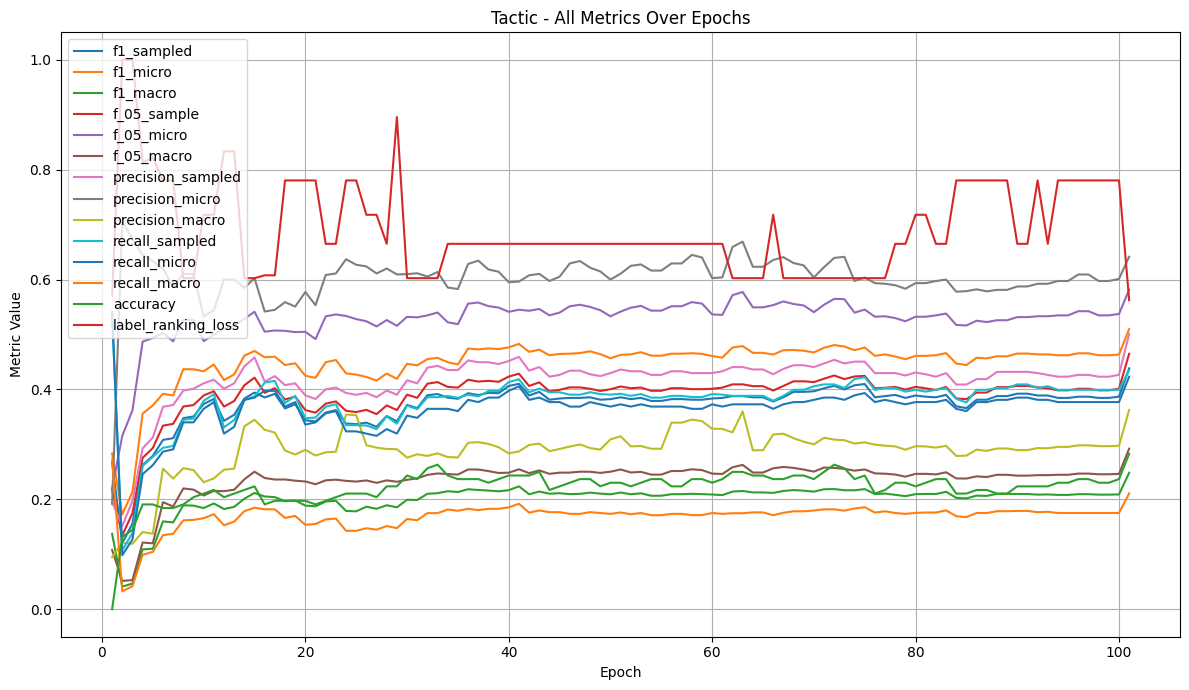

In [137]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    if metric_name != 'lrap' and metric_name != 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic - All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

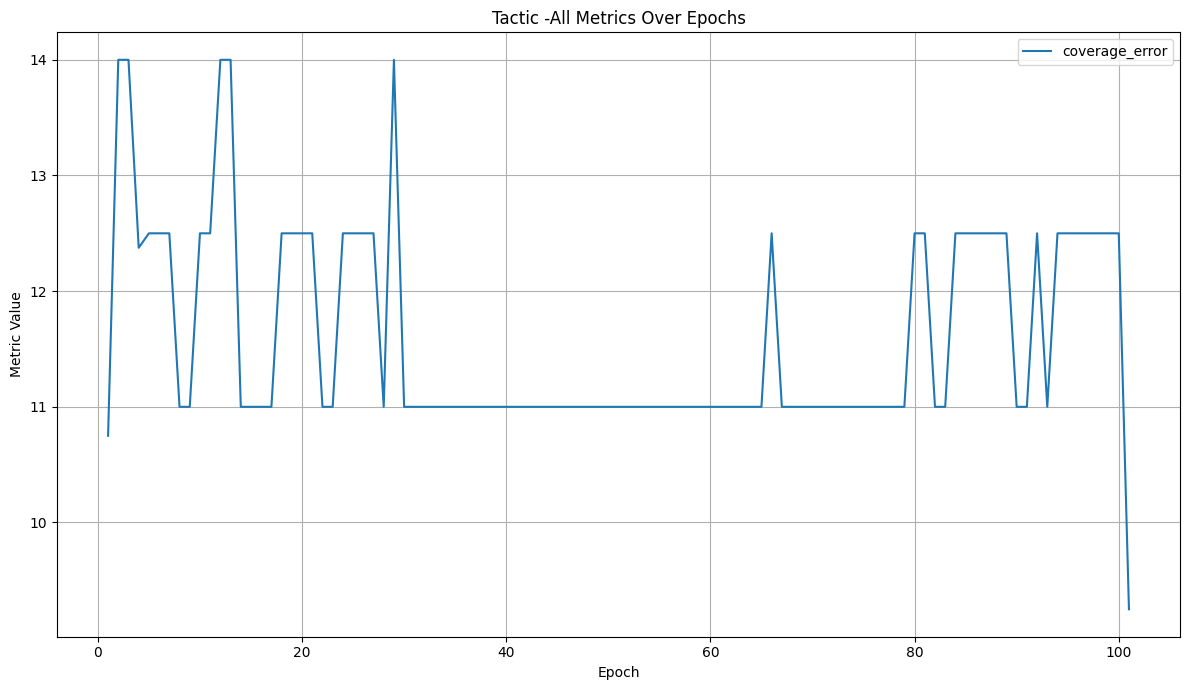

In [138]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

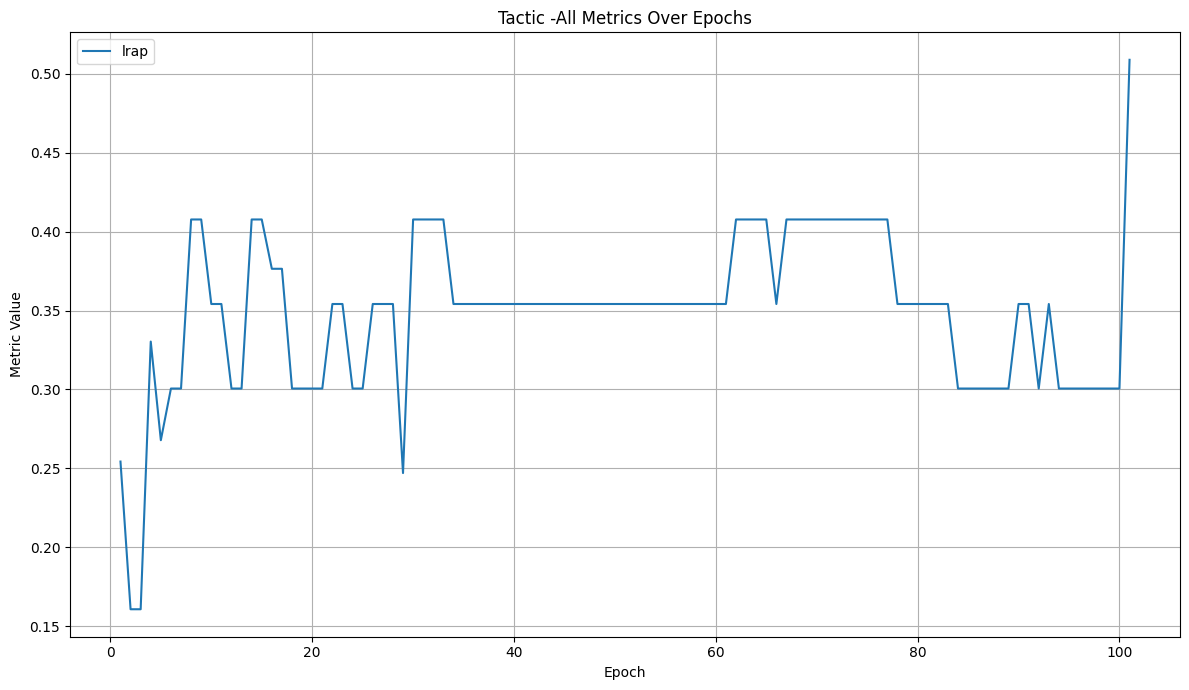

In [139]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'lrap':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [141]:
def print_precision_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = precision_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("Precision Score")

  ax = plt.gca()
  plt.show()

In [142]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  for col in sorted_results.columns[:limit]:
        print(f"{col}: {sorted_results[col].values[0]}")

  return sorted_results.iloc[:, :limit]

In [143]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df['text_clean'] = df['Text'].map(lambda t: preprocess(t))


train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)


In [144]:
print("------Validation results --------")
print(BEST_F1)

print("F1 scores per class")
y_train_df = train.drop(train.columns[0:2], axis=1)

f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, test.columns[2:16], 14)
print("----------------------------------")

print("Recall scores per class")
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, test.columns[2:16], 14)
print("----------------------------------")

print("Precision scores per class")
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, test.columns[2:16], 14)
print("----------------------------------")

print("Accuracy scores per class")
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, test.columns[2:16], 14)

------Validation results --------
0.45549023715684256
F1 scores per class
TA0040: 0.7017543859649122
TA0002: 0.6666666666666666
TA0001: 0.5238095238095238
TA0006: 0.46153846153846156
TA0009: 0.3829787234042553
TA0004: 0.3
TA0005: 0.09523809523809523
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Recall scores per class
TA0002: 0.660377358490566
TA0040: 0.625
TA0001: 0.4782608695652174
TA0006: 0.3333333333333333
TA0009: 0.32142857142857145
TA0004: 0.20689655172413793
TA0005: 0.0625
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Precision scores per class
TA0040: 0.8
TA0006: 0.75
TA0002: 0.6730769230769231
TA0001: 0.5789473684210527
TA0004: 0.5454545454545454
TA0009: 0.47368421052631576
TA0005: 0.2
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Accuracy scores per class
TA000

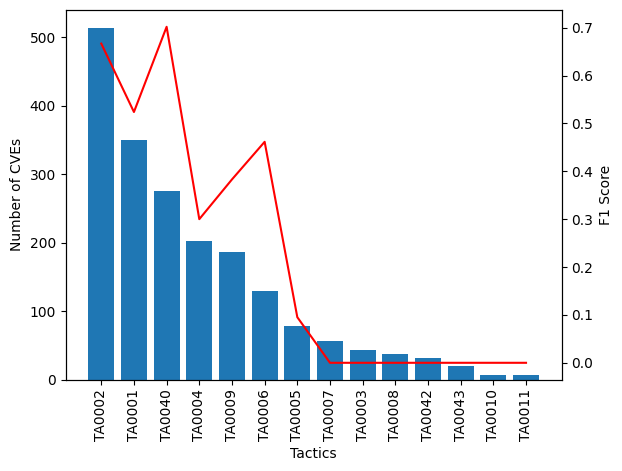

In [145]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])

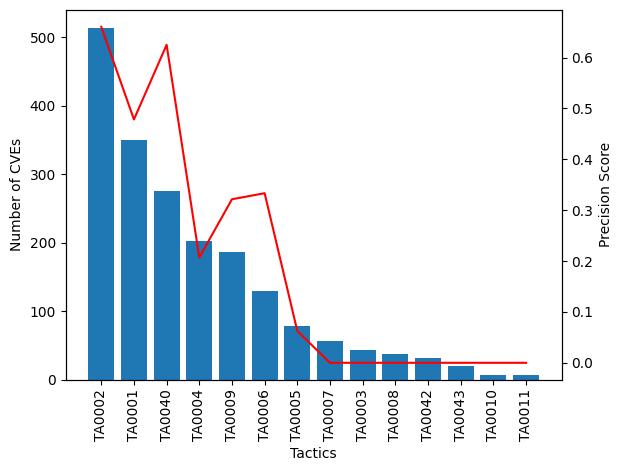

In [146]:
print_precision_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])